# MM-PIHM Output Visualization

Here we show how to visualize MM-PIHM simulation results using Python.
We use the Flux-PIHM `ShaleHills` simulation results as an example.
The simulation can be performed by running `make test` in your MM-PIHM directory.
The command will compile Flux-PIHM and run a `ShaleHills` simulation, with output files stored in the `output/ShaleHillsTestRun` directory.
An interactive version of this page can be found [here](https://colab.research.google.com/drive/1uD7ErWWUb5TFfOos6eQiX_5WZw-SV58h?usp=sharing).

In [1]:
simulation = "ShaleHills"
output_dir = "ShaleHillsTestRun"
pihm_dir = "."

## Download MM-PIHM input and output files from GitHub

To use the interactive example, download MM-PIHM input and output files from GitHub.

In [2]:
!wget -c https://github.com/PSUmodeling/MM-PIHM/raw/master/output/ShaleHillsTestRun/ShaleHills.gw.dat -P output/ShaleHillsTestRun >& /dev/null
!wget -c https://github.com/PSUmodeling/MM-PIHM/raw/master/output/ShaleHillsTestRun/ShaleHills.river.flx1.dat -P output/ShaleHillsTestRun >& /dev/null
!wget -c https://github.com/PSUmodeling/MM-PIHM/raw/master/input/ShaleHills/ShaleHills.mesh -P input/ShaleHills >& /dev/null
!wget -c https://github.com/PSUmodeling/MM-PIHM/raw/master/input/ShaleHills/ShaleHills.riv -P input/ShaleHills >& /dev/null
!echo "Download completed."

Download completed.


## Install PIHM-utils python package

`PIHM-utils` is a Python library for reading [MM-PIHM](https://github.com/PSUmodeling/MM-PIHM) input and output files.
`PIHM-utils` is published on [PyPI](https://pypi.org/project/PIHM-utils/).
The package contains three functions: `read_mesh`, `read_river`, and `read_output`.
They can be installed and imported to your project as below.




In [3]:
!pip install pihm-utils

from pihm import read_mesh
from pihm import read_river
from pihm import read_output

## Use PIHM-utils to read MM-PIHM input and output files


### `read_mesh` function

The `read_mesh` function reads mesh information from MM-PIHM `.mesh` input files:

In [4]:
num_elem, num_nodes, tri, x, y, zmin, zmax = read_mesh(pihm_dir, simulation)

where `num_elem` is the number of triangular elements,
`num_nodes` is the number of nodes, `tri` is an array of triangles consisted of nodes,
`x`, `y`, `zmin`, and `zmax` are arrays of the x and y coordinates, and bottom and surface elevations of nodes, respectively.

`pihm_dir` is the path to the MM-PIHM directory, which should contain `input` and `output` directories,
and `simulation` is the name of the simulation.


### `read_river` function

The `read_river` function reads river information from MM-PIHM `.river` input files:


In [5]:
num_rivers, from_node, to_node, outlets = read_river(pihm_dir, simulation)

where `num_rivers` is the number of river segments,
`from_nodes` and `to_nodes` are arrays of from and to nodes of river segments,
and `outlets` is an array of river outlets.

### `read_output` function

The `read_output` function reads MM-PIHM simulation output files:


In [6]:
sim_time, sim_val, vname, unit = read_output(pihm_dir, simulation, output_dir, 'gw')

where `sim_time` is an array of simulation time steps,
`sim_val` is an array of output values containing simulation results from all model grids at all model steps,
and `vname` and `unit` are strings containing description and unit of the specific output variable.
The function requires the input of the name of output variable (i.e., `gw` in this example, which represents groundwater storage).
For a complete list of available output variables, please refer to the MM-PIHM User's Guide.

## Plot variable spatial distribution


MM-PIHM uses irregular triangular grids.
Matplotlib `tripcolor` function can be used to plot MM-PIHM simulation results in space.

In [7]:
# Import other packages needed for visualization
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.collections import LineCollection

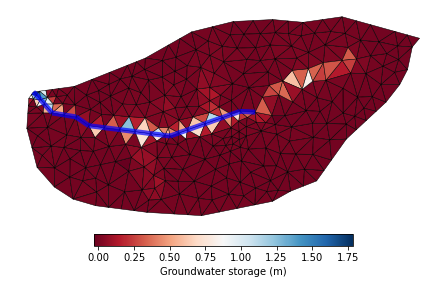

In [8]:
# In the test run, model starts on 20 Oct, 2008. The simulation period from 20 Oct to 31 Dec 2009 is used as spin-up,
# and is excluded from visualization
sim_val = sim_val[sim_time >= datetime(2009, 1, 1), :]
sim_time = sim_time[sim_time >= datetime(2009, 1, 1)]

# Create line collection of river segments for plotting
lines = [[(x[node1], y[node1]), (x[node2], y[node2])] for (node1, node2) in zip(from_node, to_node)]
river_segments = LineCollection(
    lines,
    linewidths=5,
    colors='blue',
    alpha=0.7,
    linestyle='solid',
)

fig = plt.figure()

# Test the shape of domain to determine if portrait or landscape mode should be used
domain_xy_ratio = (np.max(x) - np.min(x)) / (np.max(y) - np.min(y))
ax = fig.add_axes([0, 0, 0.8, 1]) if domain_xy_ratio < 1.33 else fig.add_axes([0, 0.2, 1, 0.8])

# Plot output in space
tpc = ax.tripcolor(
    x, y, tri,
    facecolors=np.average(sim_val, axis=0),     # Average in time
    edgecolors='k',
    lw=0.5,
    cmap='RdBu'
)
ax.add_collection(river_segments)
ax.set_aspect('equal')

# Add color bar with variable name and unit
if domain_xy_ratio < 1.33:
    cbaxes = fig.add_axes([0.8, 0.2, 0.025, 0.6])
    cbar = fig.colorbar(tpc, cax=cbaxes)
else:
    cbaxes = fig.add_axes([0.2, 0.15, 0.6, 0.04])
    cbar = fig.colorbar(tpc, orientation='horizontal', cax=cbaxes)
cbar.set_label(label='%s (%s)' % (vname, unit))
ax.axis('off')

plt.show()

## Plot time series

This example plots temporal variations of river discharge (`river.flx1` at river outlets).

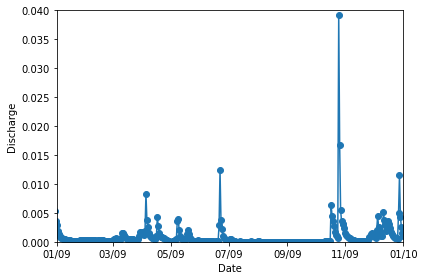

In [9]:
sim_time, sim_val, vname, unit = read_output(pihm_dir, simulation, output_dir, 'river.flx1')

# Plot average in time
fig, ax = plt.subplots()
#ax.plot(sim_time, np.average(sim_val, axis=1), '-o')
ax.plot(sim_time, sim_val[:, outlets], '-o')

# Set x and y axis labels
ax.set_xlabel('Date')
ax.set_ylabel('Discharge')
ax.set_xlim(datetime(2009, 1, 1), datetime(2010, 1, 1))
ax.set_ylim([0, 0.04])

# Clean up the x axis dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%y"))
fig.tight_layout()  # Otherwise y-label could be slightly clipped